Adapted from https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/01-basics/pytorch_basics/main.py

In [1]:
import torch
import torchvision
import torch.nn as nn 
import numpy as np 
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable

In [2]:
DATA_FOLDER = './torch_data/CIFAR10'

# Implementing an input pipeline

In [3]:
# Download and transform dataset.
train_dataset = dsets.CIFAR10(root=DATA_FOLDER,
                              train=True,
                              transform=transforms.ToTensor(),
                              download=True)

Files already downloaded and verified


## select one data pair (read data from disk).

In [4]:
image, label = train_dataset[0]

In [5]:
image.size()

torch.Size([3, 32, 32])

In [6]:
image.shape

torch.Size([3, 32, 32])

In [7]:
label

6

## Data Loader
This provides queue and thread in a very simple way


In [8]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=64,
                                        shuffle=True,
                                        num_workers=2)

When iteration starts, queue and thread start to load dataset from files

In [9]:
data_iter = iter(train_loader)

Mini-batch images and labels

In [10]:
images, labels = data_iter.next()

In [11]:
images.shape

torch.Size([64, 3, 32, 32])

In [12]:
labels.shape

torch.Size([64])

Actual usage of data loader is as below

In [13]:
for images, labels in train_loader:
    # Your training code will be written here
    pass

# Input pipeline for custom dataset

This section is based on http://pytorch.org/tutorials/beginner/data_loading_tutorial.html

A custom dataset loader can be built as follows:

In [26]:
from __future__ import print_function, division
import os
import pathlib
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [15]:
landmarks_frame = pd.read_csv('./torch_data/faces/face_landmarks.csv')

In [16]:
landmarks_frame.head()

,image_name,part_0_x,part_0_y,part_1_x,part_1_y,part_2_x,part_2_y,part_3_x,part_3_y,part_4_x,...,part_63_x,part_63_y,part_64_x,part_64_y,part_65_x,part_65_y,part_66_x,part_66_y,part_67_x,part_67_y
0,0805personali01.jpg,27,83,27,98,29,113,33,127,39,...,93,136,100,141,93,135,89,135,84,134
1,1084239450_e76e00b7e7.jpg,70,236,71,257,75,278,82,299,90,...,148,311,179,308,149,312,137,314,128,312
2,10comm-decarlo.jpg,66,114,65,128,67,142,68,156,72,...,128,162,136,167,127,166,121,165,116,164
3,110276240_bec305da91.jpg,42,140,45,161,51,180,61,200,73,...,144,197,180,189,147,204,136,208,125,209
4,1198_0_861.jpg,138,392,141,427,145,464,152,501,166,...,293,507,331,511,294,516,279,518,265,516


In [21]:
landmarks_frame.shape

(69, 137)

Let’s quickly read the CSV and get the annotations in an (N, 2) array where N is the number of landmarks.

In [20]:
n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
print(landmarks.shape)
landmarks = landmarks.astype('float32').reshape(-1, 2)
print(landmarks.shape)

(136,)
(68, 2)


In [23]:
print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))


Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks: [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


In [29]:
path = pathlib.Path('./torch_data/')

In [32]:
path/'faces/'/img_name

PosixPath('torch_data/faces/person-7.jpg')

Let’s write a simple helper function to show an image and its landmarks and use it to show a sample.

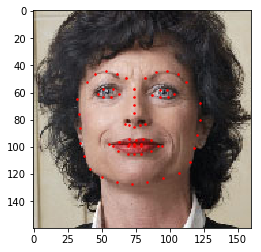

In [33]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_landmarks(io.imread(path/'faces/'/img_name),landmarks)
plt.show()

In [34]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = self.root_dir/self.landmarks_frame.iloc[idx, 0]
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [36]:
face_dataset = FaceLandmarksDataset(csv_file=pathlib.Path('./torch_data/faces/face_landmarks.csv'),
                                    root_dir=pathlib.Path('./torch_data/faces/'))

0 (324, 215, 3) (68, 2)


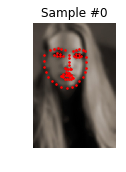

1 (500, 333, 3) (68, 2)


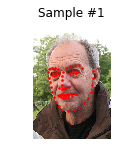

2 (250, 258, 3) (68, 2)


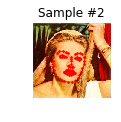

3 (434, 290, 3) (68, 2)


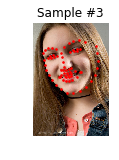

In [40]:
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    print(i, sample['image'].shape, sample['landmarks'].shape)
    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

## Transforms

One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some prepocessing code. Let’s create three transforms:

    Rescale: to scale the image
    RandomCrop: to crop from image randomly. This is data augmentation.
    ToTensor: to convert the numpy images to torch images (we need to swap axes).

We will write them as callable classes instead of simple functions so that parameters of the transform need not be passed everytime it’s called. For this, we just need to implement `__call__` method and if required, `__init__` method. We can then use a transform like this:

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)

In [42]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

## Compose transforms

Now, we apply the transforms on an sample.

Let’s say we want to rescale the shorter side of the image to 256 and then randomly crop a square of size 224 from it. i.e, we want to compose `Rescale` and `RandomCrop` transforms. `torchvision.transforms.Compose` is a simple callable class which allows us to do this.

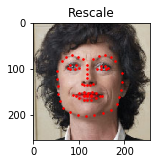

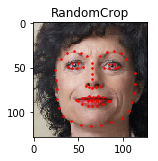

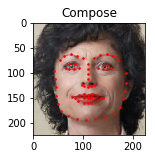

In [45]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()


## Iterating through the dataset

Let’s put this all together to create a dataset with composed transforms. To summarize, every time this dataset is sampled:

    An image is read from the file on the fly
    Transforms are applied on the read image
    Since one of the transforms is random, data is augmentated on sampling

We can iterate over the created dataset with a for i in range loop as before.

In [48]:
transformed_dataset = FaceLandmarksDataset(csv_file=pathlib.Path('./torch_data/faces/face_landmarks.csv'),
                                    root_dir=pathlib.Path('./torch_data/faces/'),
                                    transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

In [49]:

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break


0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


However, we are losing a lot of features by using a simple for loop to iterate over the data. In particular, we are missing out on:

    Batching the data
    Shuffling the data
    Load the data in parallel using multiprocessing workers.

`torch.utils.data.DataLoader` is an iterator which provides all these features. Parameters used below should be clear. One parameter of interest is collate_fn. You can specify how exactly the samples need to be batched using collate_fn. However, default collate should work fine for most use cases.

In [50]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)

0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


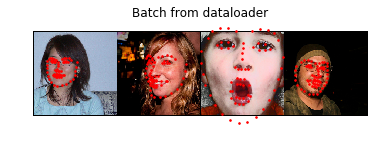

In [51]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break
